In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import time
import matplotlib.pyplot as plt

import lcmpc.dubins_dynamics as dubins_dynamics
from lcmpc.dubins_dynamics import DubinsDynamics
from lcmpc.multi_agent_optimization import MultiAgentOptimization
from lcmpc.occupancy_map import OccupancyMap
from lcmpc.loop_closure_aware_mpc import LoopClosureAwareMPC

In [2]:
# Define the occupancy map

map_size_x = 30
map_size_y = 30
num_obstacles = 10
start_x = 25
start_y = 2
goal_x = 5
goal_y = 20

map = OccupancyMap(map_size_x, map_size_y, num_obstacles, start_x, start_y, goal_x, goal_y)

In [3]:
# Define the dynamics

dubins = DubinsDynamics(control=dubins_dynamics.CONTROL_LIN_ACC_ANG_VEL)
deg2rad = np.pi/180
x_bounds = np.array([
    [-30., 30.],
    [-30., 30.],
    [-10., 10.],
    [-np.inf, np.inf]
])
u_bounds = np.array([
    [-5, 5],
    [-45*deg2rad, 45*deg2rad]
])

In [4]:
# Generate the initail guess for the trajectory

dubins = DubinsDynamics(control=dubins_dynamics.CONTROL_LIN_ACC_ANG_VEL)
x0 = np.array([[map.start_x, map.start_y, 0.0, 0.0]])
xf = np.array([[map.goal_x, map.goal_y, 0.0, 0.0]])
# tf = 2.0
dist = np.linalg.norm(xf[0, 0:2] - x0[0, 0:2])
tf = abs(dist/u_bounds[0, 0]*3)
print(tf)
# initial guess for the trajectory

# initial guess
point1 = [10, 20, 0, 0]
num_timesteps = 30
# create a path from x0 to point1 for each 4 elements

first_path_first_element = np.interp(np.linspace(0, 1, num_timesteps-20+1), [0, 1], [x0[0, 0], point1[0]])
first_path_second_element = np.interp(np.linspace(0, 1, num_timesteps-20+1), [0, 1], [x0[0, 1], point1[1]])
first_path_third_element = np.interp(np.linspace(0, 1, num_timesteps-20+1), [0, 1], [x0[0, 2], point1[2]])
first_path_fourth_element = np.interp(np.linspace(0, 1, num_timesteps-20+1), [0, 1], [x0[0, 3], point1[3]])

second_path_first_element = np.interp(np.linspace(0, 1, 20+1), [0, 1], [point1[0], xf[0, 0]])
second_path_second_element = np.interp(np.linspace(0, 1, 20+1), [0, 1], [point1[1], xf[0, 1]])
second_path_third_element = np.interp(np.linspace(0, 1, 20+1), [0, 1], [point1[2], xf[0, 2]])
second_path_fourth_element = np.interp(np.linspace(0, 1, 20+1), [0, 1], [point1[3], xf[0, 3]])

first_element = np.concatenate((first_path_first_element, second_path_first_element[1:]))
second_element = np.concatenate((first_path_second_element, second_path_second_element[1:]))
third_element = np.concatenate((first_path_third_element, second_path_third_element[1:]))
fourth_element = np.concatenate((first_path_fourth_element, second_path_fourth_element[1:]))

x_guess = np.array([first_element, second_element, third_element, fourth_element])
print(x_guess.shape)
# u_guess = np.zeros((dubins.u_shape, num_timesteps))
u_guess = None

# way points
waypoints={}


16.14434885648845
(4, 31)


In [5]:

terminal_cost_weight=1.0
waypoints_cost_weight=1.0
input_cost_weight=1.0
travel_cost_weight=1.0
travel_dist_cost_weight=0.01
input_rate_cost_weight=1.0
collision_cost_weight=1.0

planner = LoopClosureAwareMPC(dynamics=dubins, occupancy_map=map, num_timesteps=num_timesteps, terminal_cost_weight=terminal_cost_weight, waypoints_cost_weight=waypoints_cost_weight, input_cost_weight=input_cost_weight, travel_cost_weight=travel_cost_weight, travel_dist_cost_weight=travel_dist_cost_weight, input_rate_cost_weight=input_rate_cost_weight, collision_cost_weight=collision_cost_weight)

t_start = time.time()
planner.setup_mpc_opt(x0, xf, tf, waypoints=waypoints, x_bounds=x_bounds, u_bounds=u_bounds)
x, u, tf, cost = planner.solve_opt(x_guess, u_guess)
# x, u, tf, cost = planner.solve_opt()
t_end = time.time()
print("Optimization took {} seconds".format(t_end - t_start))
print("Optimial cost: {}".format(cost))

Optimization took 0.8509702682495117 seconds
Optimial cost: 17.063435093575052


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


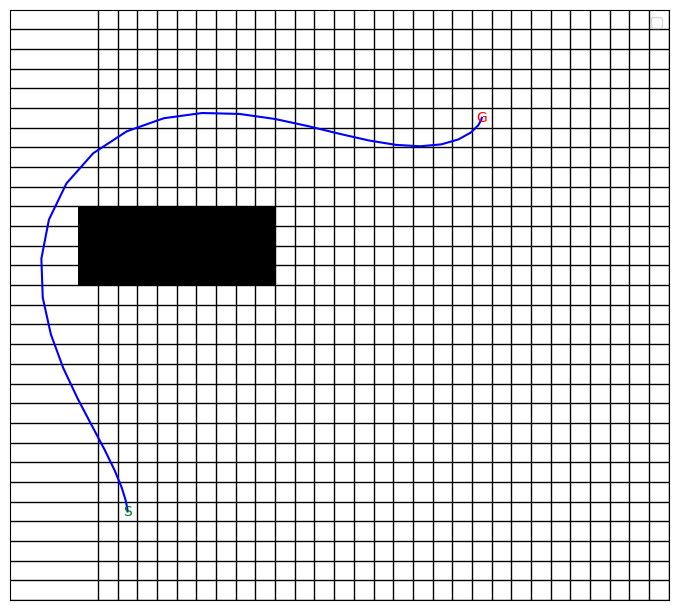

In [6]:
# Plot the results
# fig, ax = planner.draw_path()
map.plot_grid(np.array(x))
plt.legend()


